In [65]:
import os
import urllib.parse
from datetime import datetime

import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from requests import Response
from langchain_community.chat_models import ChatOllama
from IPython.display import Image, display


# Load environment variables from .env file
load_dotenv()

# Notion Custom Functions
NOTION_TOKEN = os.environ.get("NOTION_TOKEN")
DATABASE_ID = os.environ.get("NOTION_DATABASE_ID")

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}


def create_notion_page(data: dict) -> Response:
    """
    Insert a new entry to a Notion database called Book Tracker when given a dictionary with book title, status, call number, library location and updated date.
    """
    create_url = "https://api.notion.com/v1/pages"

    payload = {"parent": {"database_id": DATABASE_ID}, "properties": data}

    # Debug: Print payload
    print("Payload:", payload)
    print("Headers:", headers)

    res = requests.post(create_url, headers=headers, json=payload)
    # print(res.status_code)
    # Debug: Print response details
    print(f"Status: {res.status_code}")
    print(f"Response: {res.text}")

    if res.status_code != 200:
        print(f"Error: {res.status_code} - {res.text}")
    return res


@tool
def write_to_notion(
    book_title: str,
    call_number: str,
    status: str,
    location: str = "Sunnyvale Public Library",
    date_str: str = None,
) -> str:
    """
    Write book information to Notion database.

    Args:
        book_title: The title of the book
        call_number: The library call number
        location: The name of the library
        date_str: The date call the function on
        status: The availability status, must be among "Available now", "Not Available", "All copies in use".

    Returns:
        A message confirming the data was written to Notion
    """
    try:
        if date_str is None:
            date_str = datetime.now().strftime("%Y-%m-%d")

        notion_data = {
            "Title": {"title": [{"text": {"content": book_title}}]},
            "Status": {
                "status": {
                    "name": status
                }  # must match an existing Status option in Notion
            },
            "Call Number": {"rich_text": [{"text": {"content": call_number}}]},
            "Library Location": {"rich_text": [{"text": {"content": location}}]},
            "Date": {"date": {"start": date_str, "end": None}},
        }
        # Call the Notion API
        response = create_notion_page(notion_data)

        if response.status_code == 200:
            return f"Successfully added '{book_title}' to Notion database. Call number: {call_number}, Status: {status}"
        else:
            return f"Failed to add to Notion. Status: {response.status_code}, Response: {response.text}"

    except Exception as e:
        return f"Error writing to Notion: {str(e)}"


# Custom Tools for library catalog searching
def search_library_page(title: str) -> str:
    """
    Searches the Sunnyvale library and returns visible text from the top search result for the LLM to interpret.
    """
    encoded_title = urllib.parse.quote(title)
    search_url = f"https://sunnyvale.bibliocommons.com/v2/search?query={encoded_title}&searchType=smart"
    response = requests.get(search_url)

    if response.status_code != 200:
        return "Failed to fetch search results."

    soup = BeautifulSoup(response.text, "html.parser")

    # Extract text from multiple result cards (up to 3 results)
    result_cards = soup.find_all("li", class_="cp-search-result-item", limit=3)

    if not result_cards:
        return "No search results found."

    # Combine text from all found result cards
    all_results = []
    for i, card in enumerate(result_cards, 1):
        card_text = card.get_text(separator="\n", strip=True)
        all_results.append(f"--- Result {i} ---\n{card_text}")

    return "\n\n".join(all_results)

# Router Agent Setup -- Initialize cheaper LLM
# Ollama (local) – Llama 3.1 8B
cheap_llm = ChatOllama(model="llama3.1:8b-instruct", temperature=0)

# Worker Agent Setup -- Initialize LLM with tools
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([search_library_page, write_to_notion])


# Node function
def tool_calling_llm(state: MessagesState):
    input_messages = [
        SystemMessage(
            content="""You're a librarian good at searching library catalog. You help users to keep track of the books they've searched in a notion database. Remember that there are only 3 status are allowed for a book status: "Available now", "Not avaliable" and "All copies in use". When the search result is written to Notion successfully, stop."""
        )
    ]
    return {"messages": [llm_with_tools.invoke(input_messages + state["messages"])]}




# Router Set-up

In [47]:
from pydantic import BaseModel
from typing import Literal
from langchain.prompts import ChatPromptTemplate


# 1. Define schema
class IntentClassification(BaseModel):
    intent: Literal["search_catalog","store_book","OUT_OF_SCOPE"]
    confidence: float

# 2. Build prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", 
    """You are a user intent classifier in a library context.
    Task: Ignore greetings, pleasantries, or chit-chat. Always detect and prioritize catalog queries (searching by title/author or checking availability), even if hidden inside greetings or casual conversation.  
    Classify the main ask into one of:  
    - "search_catalog"  
    - "store_book"  
    - "OUT_OF_SCOPE".
    Reply ONLY in JSON with keys: intent, confidence (0-1)."""),
    ("human", "{text}")
])

# 3. Define model
router_llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0) #gpt-4o-mini

# 4. Build chain
chain = prompt | router_llm.with_structured_output(IntentClassification)

# 5. Test messages
tests = [
    "Find The Psychology of Money",
    "Save 332.4019 HOU to Notion",
    "How's your day?",
    "What’s the weather like in Paris?",
    "Hi, how are you? Can you find maybe you should talk to someone?",
    "Hi, how are you? Can you find 'maybe you should talk to someone'?"
]

for t in tests:
    r = chain.invoke({"text": t})
    print(f"Q: {t}\n→ {r}\n")

Q: Find The Psychology of Money
→ intent='search_catalog' confidence=0.9

Q: Save 332.4019 HOU to Notion
→ intent='OUT_OF_SCOPE' confidence=0.2

Q: How's your day?
→ intent='OUT_OF_SCOPE' confidence=0.9

Q: What’s the weather like in Paris?
→ intent='OUT_OF_SCOPE' confidence=0.9

Q: Hi, how are you? Can you find maybe you should talk to someone?
→ intent='OUT_OF_SCOPE' confidence=0.2

Q: Hi, how are you? Can you find 'maybe you should talk to someone'?
→ intent='search_catalog' confidence=0.9



In [48]:

# 3. Define model
router_llm = ChatOpenAI(model="gpt-5-mini", temperature=0) #gpt-4o-mini

# 4. Build chain
chain = prompt | router_llm.with_structured_output(IntentClassification)

# 5. Test messages
tests = [
    "Find The Psychology of Money",
    "Save 332.4019 HOU to Notion",
    "How's your day?",
    "What’s the weather like in Paris?",
    "Hi, how are you? Can you find maybe you should talk to someone?",
    "Hi, how are you? Can you find 'maybe you should talk to someone'?"
]

for t in tests:
    r = chain.invoke({"text": t})
    print(f"Q: {t}\n→ {r}\n")

Q: Find The Psychology of Money
→ intent='search_catalog' confidence=0.99

Q: Save 332.4019 HOU to Notion
→ intent='store_book' confidence=0.95

Q: How's your day?
→ intent='OUT_OF_SCOPE' confidence=0.98

Q: What’s the weather like in Paris?
→ intent='OUT_OF_SCOPE' confidence=0.95

Q: Hi, how are you? Can you find maybe you should talk to someone?
→ intent='search_catalog' confidence=0.95

Q: Hi, how are you? Can you find 'maybe you should talk to someone'?
→ intent='search_catalog' confidence=0.98



In [49]:

# 3. Define model
router_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) #gpt-4o-mini

# 4. Build chain
chain = prompt | router_llm.with_structured_output(IntentClassification)

# 5. Test messages
tests = [
    "Find The Psychology of Money",
    "Save 332.4019 HOU to Notion",
    "How's your day?",
    "What’s the weather like in Paris?",
    "Hi, how are you? Can you find maybe you should talk to someone?",
    "Hi, how are you? Can you find 'maybe you should talk to someone'?"
]

for t in tests:
    r = chain.invoke({"text": t})
    print(f"Q: {t}\n→ {r}\n")

Q: Find The Psychology of Money
→ intent='search_catalog' confidence=0.9

Q: Save 332.4019 HOU to Notion
→ intent='store_book' confidence=0.8

Q: How's your day?
→ intent='OUT_OF_SCOPE' confidence=0.0

Q: What’s the weather like in Paris?
→ intent='OUT_OF_SCOPE' confidence=0.9

Q: Hi, how are you? Can you find maybe you should talk to someone?
→ intent='search_catalog' confidence=0.8

Q: Hi, how are you? Can you find 'maybe you should talk to someone'?
→ intent='search_catalog' confidence=0.9



In [59]:
from typing import TypedDict, Optional, Annotated, Literal
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [60]:
# --- 0) Setup ---------------------------------------------------------------
SUPPORTED = {"search_catalog", "store_book", "small_talk"}
THRESH = 0.7

def cheap_router_llm(text: str) -> dict:
    """
    Cheap model returns strict JSON: {"intent": "...", "confidence": 0.0-1.0}
    Tip: use function/JSON mode, temperature=0, short max_tokens.
    """
    # 1. Define schema
    class IntentClassification(BaseModel):
        intent: Literal["search_catalog","store_book","OUT_OF_SCOPE"]
        confidence: float

    # 2. Build prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """You are a user intent classifier in a library context.
        Task: Ignore greetings, pleasantries, or chit-chat. Always detect and prioritize catalog queries (searching by title/author or checking availability), even if hidden inside greetings or casual conversation.  
        Classify the main ask into one of:  
        - "search_catalog"  
        - "store_book"  
        - "OUT_OF_SCOPE".
        Reply ONLY in JSON with keys: intent, confidence (0-1)."""),
        ("human", "{text}")
    ])
    # 3. Define model
    router_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

    # 4. Build chain
    chain = prompt | router_llm.with_structured_output(IntentClassification)

    # pseudo: replace with your client call
    resp = chain.invoke(text)
    return {"intent": resp.intent, "confidence": resp.confidence}

class AppState(TypedDict):
    messages: Annotated[list, add_messages]
    routing_result: Optional[dict]  # reducer: replace by default

# Router Node
def router_node(state: AppState) -> dict:
    user_msg = state["messages"][-1].content
    resp = cheap_router_llm(user_msg)  # {"intent":..., "confidence":...}
    # Add debug prints
    print(f"Router called with user_msg: {user_msg}")
    print(f"Router response: {resp}")
    print(f"Router returning state: {{**state, 'routing_result': resp}}")
    # Return new state instead of modifying input
    # Return new state with routing_result added
    return {"routing_result": resp}  # return partial; framework merges

    
def gate_condition(state: AppState) -> Literal["ALLOW","BLOCK"]:
    r = state.get("routing_result", {"intent":"OUT_OF_SCOPE","confidence":0.0})
    ok = (r["intent"] in SUPPORTED) and (r["confidence"] >= THRESH)
    return "ALLOW" if ok else "BLOCK"

def refuse_node(state: AppState) -> AppState:
    # intent = state["routing_result"]["intent"]
    # conf = state["routing_result"]["confidence"]
    routing_result = state["routing_result"]  # Change from "routing_result"
    intent = routing_result["intent"]
    conf = routing_result["confidence"]
    msg = (f"Sorry—I only handle catalog/search/store. "
           f"(detected: {intent}, conf={conf:.2f}). Try: “Find <book title>”.")
    return {
        "messages": [AIMessage(content=msg)]
    }


In [61]:

# Build graph
builder = StateGraph(AppState)

builder.add_node("router", router_node)
builder.add_node("refuse", refuse_node)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([search_library_page, write_to_notion]))

builder.add_edge(START, "router")

builder.add_conditional_edges("router", gate_condition, {"ALLOW":"tool_calling_llm", "BLOCK":"refuse"})

builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tools", END)




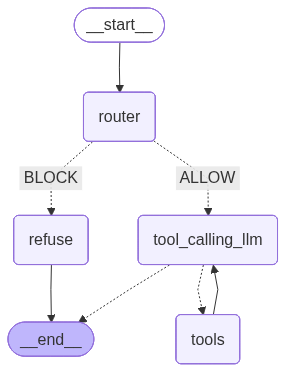

In [62]:
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
print("Graph compiled:", graph is not None)
print("Graph nodes:", list(graph.nodes.keys()))

Graph compiled: True
Graph nodes: ['__start__', 'router', 'refuse', 'tool_calling_llm', 'tools']


In [68]:
# input_messages = [HumanMessage(content="what formats of 'Maybe you should talk to someone' are there in the library?")]


# input_messages = [
#   HumanMessage(content="Find 'Same as It Ever Was'")
# ]

input_messages = [
    HumanMessage(content = "Hi, how are you?")
]
messages = graph.invoke({"messages": input_messages})

# Print the result structure for debugging
print("Result keys:", messages.keys())
print("Number of messages:", len(messages['messages']))

for m in messages['messages']:
    m.pretty_print()

Router called with user_msg: Hi, how are you?
Router response: {'intent': 'OUT_OF_SCOPE', 'confidence': 0.9}
Router returning state: {**state, 'routing_result': resp}
Result keys: dict_keys(['messages', 'routing_result'])
Number of messages: 2
================================ Human Message =================================

Hi, how are you?
================================== Ai Message ==================================

Sorry—I only handle catalog/search/store. (detected: OUT_OF_SCOPE, conf=0.90). Try: “Find <book title>”.
